# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import XGBoostClassifier

# Directories

In [2]:
track = 'Long'
particle = 'Electron'

data_path = "../../../data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"multiclass/Long/XGBoost"

netconfig_path = "../../../data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [3]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [6]:
data = pandas.read_csv(data_path + "/data_train.csv")

In [7]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

# Balance data

In [8]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  170119
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  774220
Size of class 4 is  138261
Size of class 5 is  81951


In [9]:
selected_indexes = []

numpy.random.seed = 42

for i in numpy.unique(labels):
    
    indxs = numpy.random.choice(data.index[labels == i], 
                                size=min(50000, len(labels[labels == i])), 
                                replace=False)
    
    selected_indexes += list(indxs)

In [10]:
data.loc[selected_indexes].to_csv(data_path + "/data_train_balanced.csv")

# Read balanced data

In [11]:
data = pandas.read_csv(data_path + "/data_train_balanced.csv", index_col=0)

In [12]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [13]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  50000
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  50000
Size of class 4 is  50000
Size of class 5 is  50000


# Features

In [20]:
# All allowable features
features = ['VeloCharge', 'BremPIDe', 'CaloNeutralPrs', 'CaloNeutralSpd', 'InAccBrem', 'InAccSpd', 'CaloPrsE',
            'InAccPrs', 'HcalPIDe', 'CaloHcalE', 'InAccHcal', 'CaloTrajectoryL', 'EcalPIDe', 'CaloNeutralEcal',
            'CaloTrMatch', 'CaloElectronMatch', 'CaloChargedPrs', 'CaloChargedSpd', 'MuonNShared', 'CaloBremMatch',
            'MuonIsLooseMuon', 'MuonIsMuon', 'MuonBkgLL', 'InAccEcal', 'MuonMuLL', 'TrackMatchChi2', 
            'TrackGhostProbability','EcalPIDmu', 'TrackPt', 'TrackP', 'NumProtoParticles', 'RichAboveMuThres',
            'NumCaloHypos', 'InAccMuon', 'TrackChi2PerDof', 'TrackNumDof', 'NumUpstreamTracks', 'NumLongTracks',
            'NumDownstreamTracks', 'CaloEcalChi2', 'NumRich1Hits', 'NumMuonTracks', 'CombDLLmu', 'CaloSpdE',
            'PrsPIDe', 'HcalPIDmu', 'NumSPDHits', 'NumVeloTracks', 'NumTTracks', 'TrackFitMatchChi2', 'CombDLLpi',
            'RichDLLbt', 'RichDLLpi', 'TrackCloneDist', 'TrackFitVeloNDoF', 'NumPVs', 'CombDLLp', 'TrackFitTChi2',
            'TrackFitTNDoF', 'RichAboveElThres', 'RichUsedAero', 'TrackDOCA', 'RichDLLe', 'TrackLikelihood',
            'CombDLLe', 'CombDLLk', 'CaloClusChi2', 'TrackFitVeloChi2', 'RichDLLp', 'RichUsedR1Gas', 'CaloBremChi2',
            'RichUsedR2Gas', 'CaloEcalE', 'RichAbovePiThres', 'CaloChargedEcal', 'NumRich2Hits', 'RichAboveKaThres',
            'RichAbovePrThres', 'RichDLLmu', 'RichDLLk']

# Train XGBoost

In [21]:
weights = numpy.zeros(len(labels))

for one_lab in labs:
    
    weights += 0.01 * (labels == one_lab) * len(labels) / ((labels == one_lab).sum())
    
numpy.unique(weights)

array([ 0.0470898 ,  0.07890646,  0.41969519])

In [22]:
for i in numpy.unique(labels):
    print "Weight of class %d is " % i, weights[labels == i][0]

Weight of class 0 is  0.0470898
Weight of class 1 is  0.419695187166
Weight of class 2 is  0.0789064646939
Weight of class 3 is  0.0470898
Weight of class 4 is  0.0470898
Weight of class 5 is  0.0470898


In [23]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test, weights_train, weights_test = train_test_split(data.index, 
                                                                                                 labels, 
                                                                                                 weights, 
                                                                                                 test_size=0.25, 
                                                                                                 random_state=42)

In [24]:
%%time

clf = XGBoostClassifier(n_estimators=1000, 
                        colsample=0.7, 
                        eta=0.01, 
                        nthreads=4, 
                        subsample=0.5, 
                        max_depth=8,
                        min_child_weight = 50,
                        features=features)

clf.fit(data.loc[train_inds], labels_train, sample_weight=weights_train)

CPU times: user 7h 39min 31s, sys: 40.7 s, total: 7h 40min 11s
Wall time: 3h 10min 9s


# Feature importances

In [62]:
clf.feature_importances_

IndexError: index 77 is out of bounds for axis 0 with size 75

# Save the classifier

In [26]:
params = clf.get_params()
params_str = ""
for key, val in zip(params.keys(), params.values()):
    if key != "features":
        params_str += key + "=" + str(val) + ";"

In [27]:
new_work_path = work_path + "/" + params_str + 'balanced_data_' + str(len(data)) + 'all_features'
new_work_path

'baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=50;colsample=0.7;max_depth=8;gamma=None;nthreads=4;balanced_data_235449all_features'

In [28]:
# Save classifier
import os
if not os.path.exists(new_work_path):
    os.makedirs(new_work_path)

clf_pickle = open(new_work_path + '/classifier.pkl', 'wb')
pickle.dump(clf, clf_pickle)
clf_pickle.close()

In [ ]:
# new_work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/\
# one_vs_all/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;\
# base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=50;colsample=0.7;max_depth=8;\
# gamma=None;nthreads=4;balanced_data_235449"

In [ ]:
# Read classifier
# clf_pickle2 = open(new_work_path + '/classifier.pkl', 'rb')
# clf = pickle.load(clf_pickle2)
# clf_pickle2.close()

# Test the classifier

In [29]:
%%time
probas = clf.predict_proba(data.loc[test_inds])

CPU times: user 3min 18s, sys: 190 ms, total: 3min 18s
Wall time: 1min 3s


In [30]:
probas[:5, :]

array([[  1.46774878e-03,   9.09837952e-04,   4.22092882e-04,
          7.54533976e-04,   9.78075266e-01,   1.83705855e-02],
       [  1.15451925e-02,   1.52612745e-03,   2.04627239e-03,
          5.21187717e-03,   5.07876873e-01,   4.71793652e-01],
       [  9.48965490e-01,   4.48637791e-02,   1.60540687e-03,
          2.01669964e-03,   1.25575915e-03,   1.29286002e-03],
       [  8.66164342e-02,   6.38024136e-03,   1.38852037e-02,
          5.04162014e-01,   2.65700489e-01,   1.23255610e-01],
       [  5.73103614e-02,   1.44035358e-03,   2.21151393e-03,
          5.35729289e-01,   3.43531221e-02,   3.68955374e-01]], dtype=float32)

### Logloss

In [31]:
from sklearn.metrics import log_loss

log_loss(labels_test, probas)

0.64752440962942781

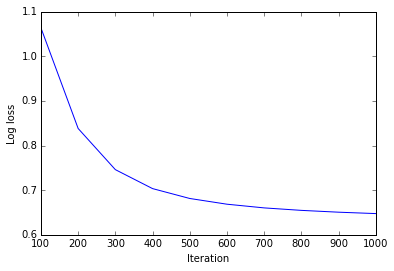

In [32]:

step = clf.get_params()['n_estimators'] / 10
staged_probas = clf.staged_predict_proba(data.loc[test_inds], step=step)

from sklearn.metrics import log_loss
log_loss_all = []
for pred in staged_probas:
    log_loss_all.append(log_loss(labels_test, pred))

x = numpy.arange(step, clf.get_params()['n_estimators'] + step, step)
plt.plot(x, log_loss_all)
plt.ylabel('Log loss')
plt.xlabel('Iteration')
plt.show()

### Roc curves

In [33]:
import os, sys
sys.path.append('../python')
import utils

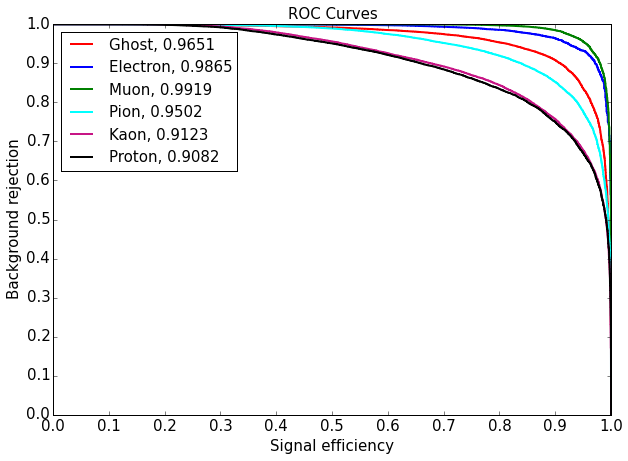

In [34]:
utils.get_roc_curves(labels_test, probas, particles, save_path=None, show=True)

# Evaluation

In [38]:
import os, sys
sys.path.append('../python')
import utils

In [39]:
data_eval = pandas.read_csv(data_path + "/data_eval.csv")

In [40]:
mc_p_type_eval = numpy.abs(data_eval.MCParticleType.values)
labels_eval = numpy.zeros(len(mc_p_type_eval))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels_eval += one_lab * (mc_p_type_eval == pdg)
    
numpy.unique(labels_eval)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [41]:
%%time
proba_eval = clf.predict_proba(data_eval)

CPU times: user 55min 22s, sys: 7.17 s, total: 55min 29s
Wall time: 17min 43s


In [42]:
numpy.savetxt(new_work_path + '/xgboost_proba_eval.csv', proba_eval)

In [43]:
#proba_eval = numpy.loadtxt(new_work_path + '/xgboost_proba_eval.csv')

In [44]:
proba_eval[:5, :]

array([[  2.63482146e-03,   5.47987735e-03,   7.40350969e-03,
          4.61195502e-03,   1.22652724e-01,   8.57217133e-01],
       [  4.90092067e-03,   1.58153649e-03,   1.01615698e-03,
          1.71747769e-03,   4.10231411e-01,   5.80552518e-01],
       [  1.40154399e-02,   5.88962226e-04,   4.76899557e-03,
          9.43651736e-01,   1.76817682e-02,   1.92931313e-02],
       [  2.70208955e-01,   5.19273020e-02,   6.42330758e-03,
          5.31219780e-01,   5.53999171e-02,   8.48207027e-02],
       [  8.23117048e-03,   4.64111858e-04,   6.48613903e-04,
          9.87822473e-01,   1.33726501e-03,   1.49639219e-03]], dtype=float32)

### Get all figures from baseline

In [18]:
from get_figures import all_figures

In [19]:
for num in range(0, len(particles)):
        
    one_particle = particles[num]
    one_lab = labs[num]

    one_labels = (labels_eval == one_lab)*1
    one_probas = numpy.concatenate((1.-proba_eval[:, num].reshape(-1,1), proba_eval[:, num].reshape(-1,1)),axis=1)
    
    params = {}
    params['PARTICLE'] = one_particle
    params['TRACK'] = 'Long'
    
    all_figures(params, data_eval, one_probas, one_labels, features, path= new_work_path + "/"+ one_particle +"/pic")

### Logloss

In [45]:
from sklearn.metrics import log_loss

logloss = log_loss(labels_eval, proba_eval)
logloss

0.65064785580959539

### Roc curves, roc auc matrix and roc auc ratio matrix

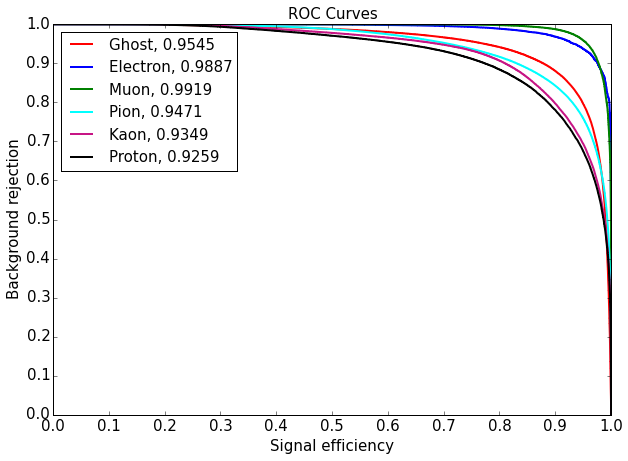

In [46]:
utils.get_roc_curves(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)

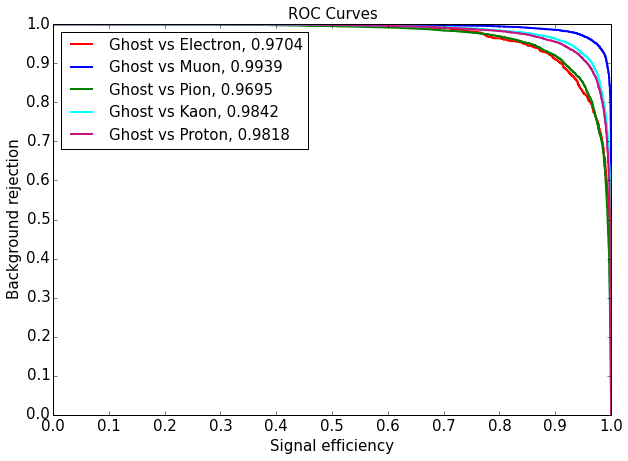

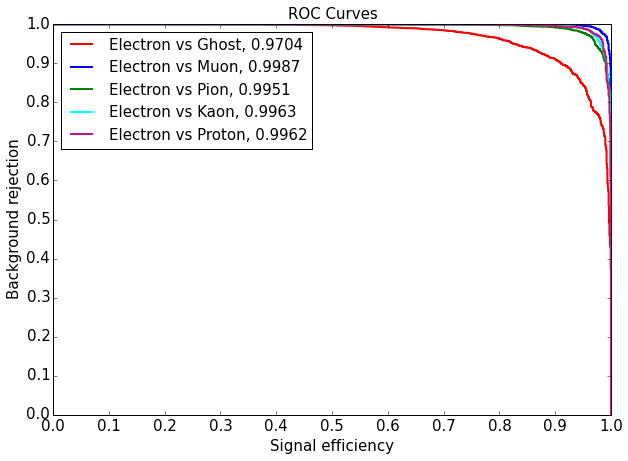

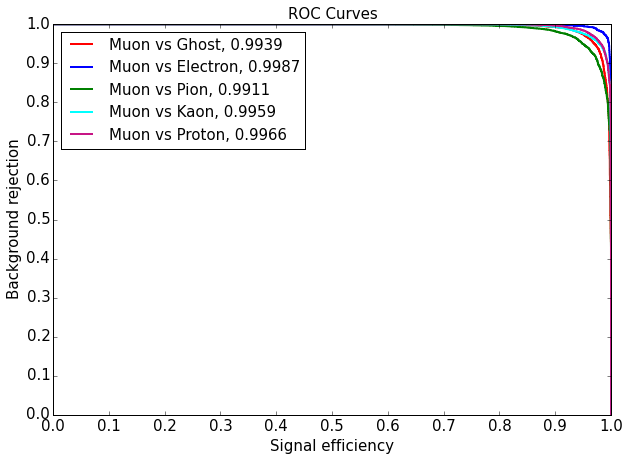

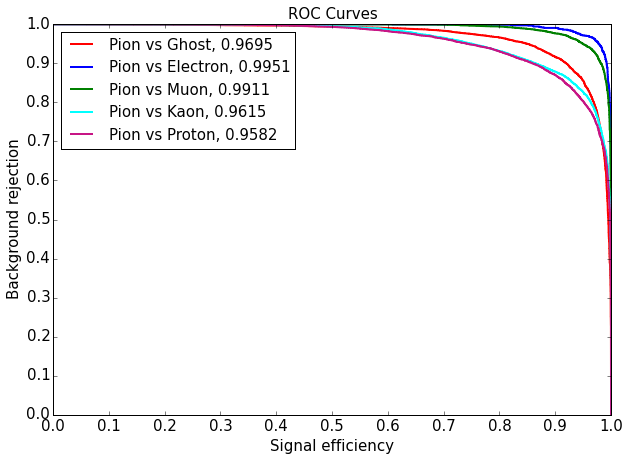

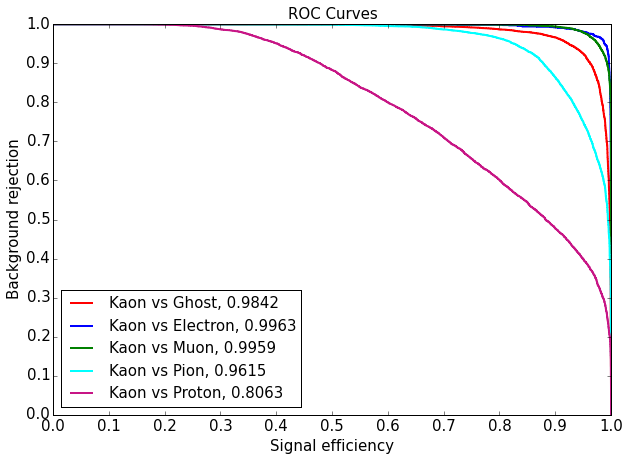

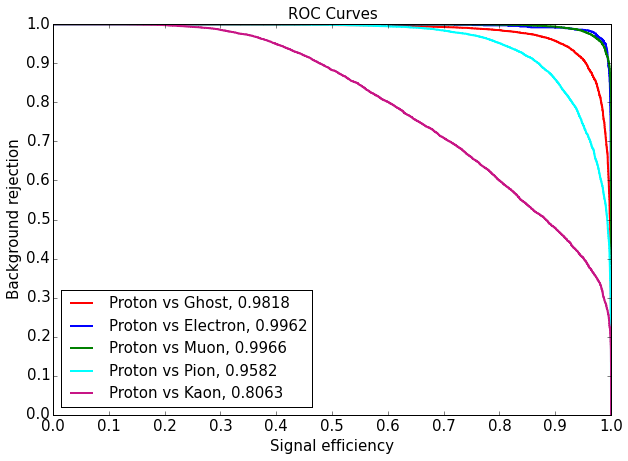

In [47]:
utils.get_one_vs_one_roc_curves(labels_test, probas, particles, save_path=new_work_path, show=True)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


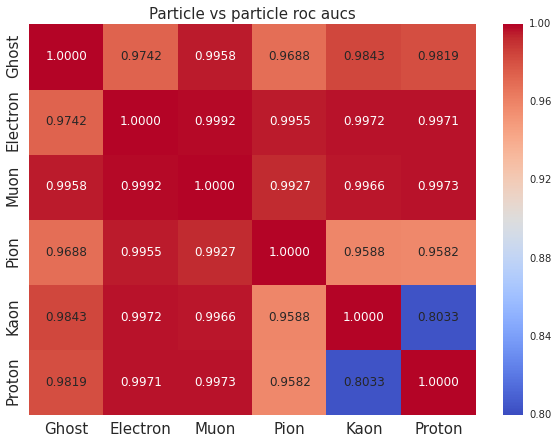

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,0.974191,0.995826,0.968753,0.984276,0.981920
Electron,0.974191,1.000000,0.999174,0.995516,0.997153,0.997124
Muon,0.995826,0.999174,1.000000,0.992686,0.996578,0.997262
Pion,0.968753,0.995516,0.992686,1.000000,0.958816,0.958186
Kaon,0.984276,0.997153,0.996578,0.958816,1.000000,0.803313
Proton,0.981920,0.997124,0.997262,0.958186,0.803313,1.000000


In [48]:
roc_auc_matrix = utils.get_roc_auc_matrix(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)
roc_auc_matrix

In [49]:
roc_auc_matrix_baseline = pandas.read_csv("../python/class_vs_class_roc_auc_matrix_baseline.csv", index_col=0)

In [61]:
mean = 0
for one in range(0, 6):
    for two in range(0, 6):
        if one >= two:
            continue
        mean += roc_auc_matrix.iloc[one, two] / 15
        
mean

0.97338495711476014

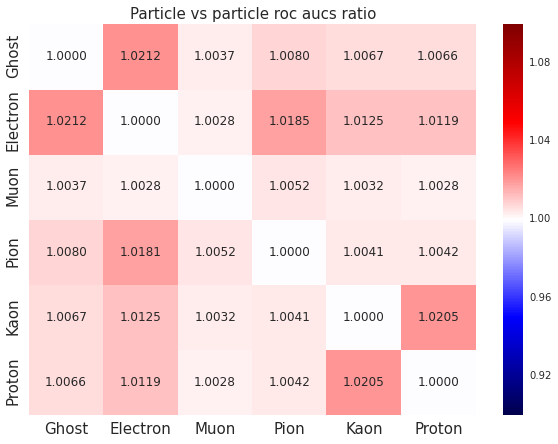

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,1.021216,1.003740,1.007992,1.006710,1.006568
Electron,1.021216,1.000000,1.002796,1.018482,1.012456,1.011949
Muon,1.003740,1.002793,1.000000,1.005177,1.003222,1.002805
Pion,1.007992,1.018148,1.005151,1.000000,1.004063,1.004220
Kaon,1.006710,1.012490,1.003222,1.004063,1.000000,1.020508
Proton,1.006568,1.011944,1.002805,1.004219,1.020508,1.000000


In [50]:
utils.get_roc_auc_ratio_matrix(roc_auc_matrix, roc_auc_matrix_baseline, save_path=new_work_path, show=True)

### Flatness

In [51]:
%%time
flatness = utils.get_flatness_table(data_eval, labels_eval, proba_eval, particles, save_path=new_work_path)

CPU times: user 17min 54s, sys: 2.03 s, total: 17min 56s
Wall time: 17min 56s


In [52]:
flatness

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Ghost,0.003720,0.012112,0.000871,0.000860
Electron,0.010289,0.031432,0.000995,0.001000
Muon,0.032362,0.042454,0.000898,0.000903
Pion,0.017900,0.015308,0.000851,0.000854
Kaon,0.048498,0.032120,0.000869,0.000884
Proton,0.037021,0.041795,0.000886,0.000874


In [58]:
flatness[['TrackP', 'TrackPt']].values.mean()

0.02708425325642401

In [53]:
flatness_baseline = pandas.read_csv("../python/flatness_baseline.csv", index_col=0)
flatness_baseline

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Electron,0.006546,0.016579,0.001014,0.001004
Proton,0.034632,0.044571,0.000886,0.000888
Pion,0.016512,0.013729,0.000853,0.000851
Muon,0.020388,0.044991,0.000905,0.000906
Kaon,0.043074,0.036657,0.000872,0.000880
Ghost,0.006591,0.014187,0.000871,0.000870


In [54]:
utils.get_flatness_ratio(flatness, flatness_baseline, save_path=new_work_path)

,TrackP,TrackPt
Ghost,0.564364,0.853688
Electron,1.571821,1.895891
Muon,1.587336,0.943612
Pion,1.084047,1.115062
Kaon,1.125932,0.876215
Proton,1.068979,0.937719


### Efficiency curves

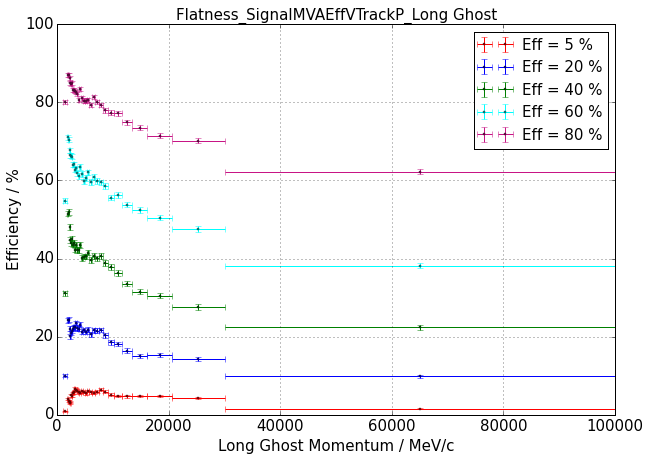

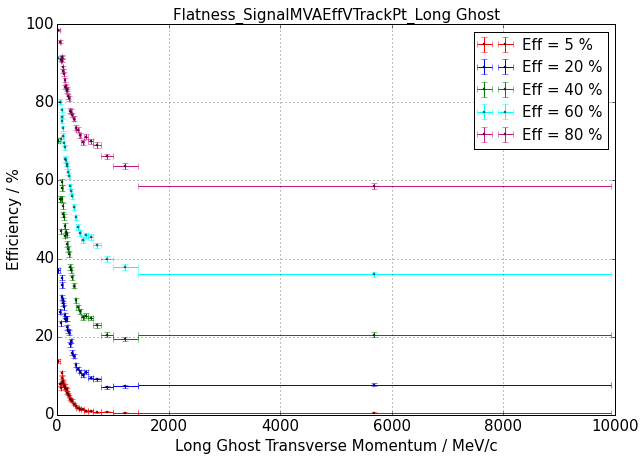

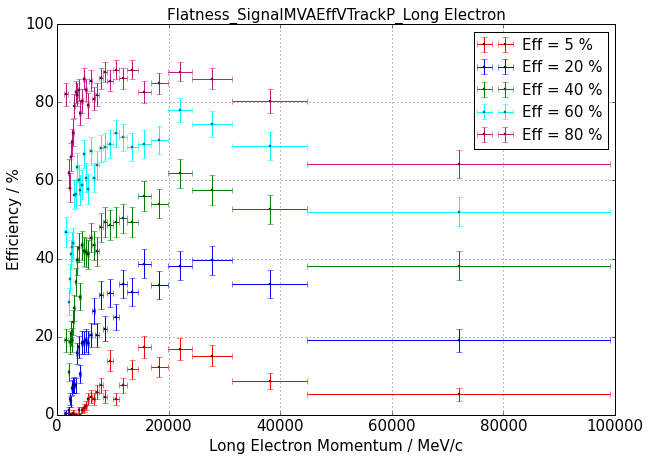

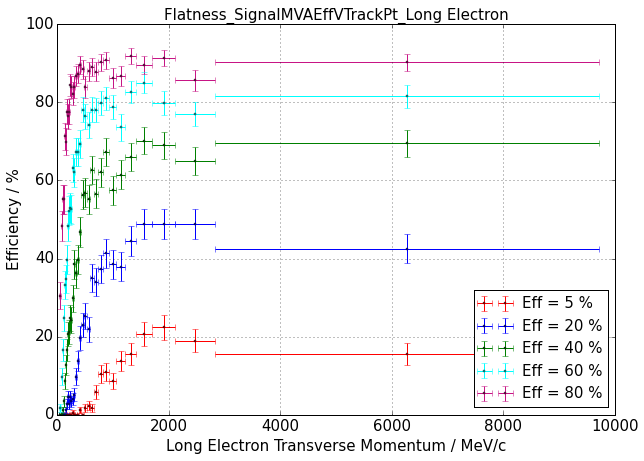

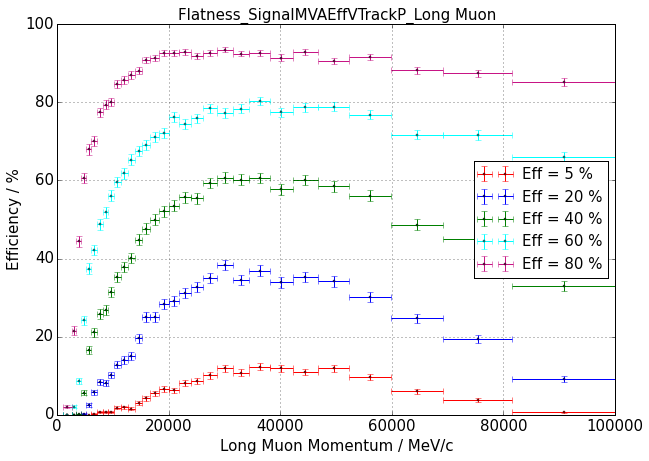

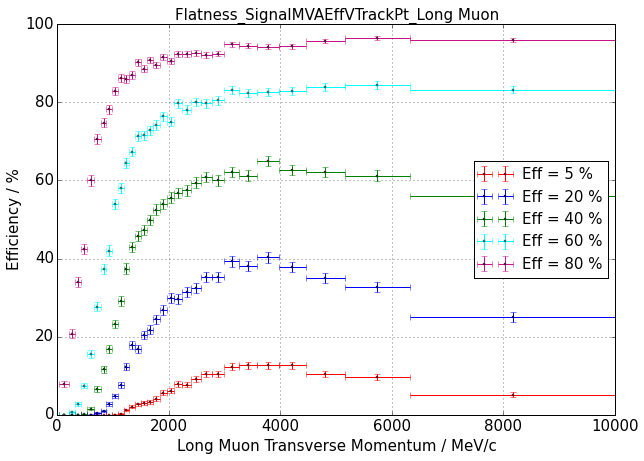

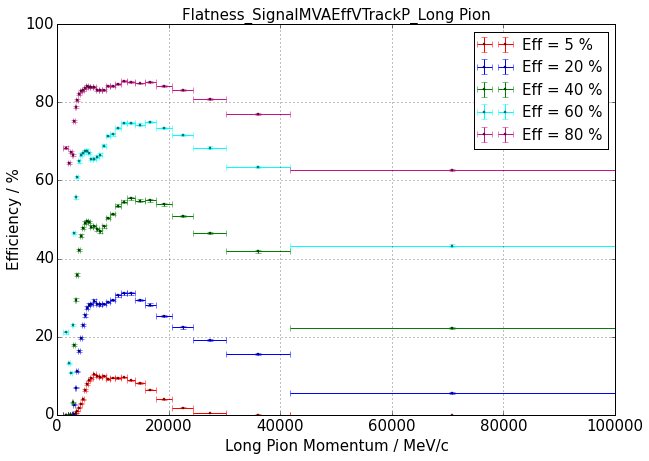

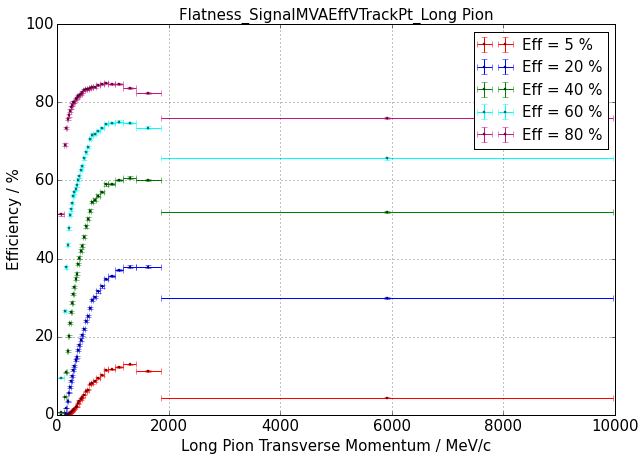

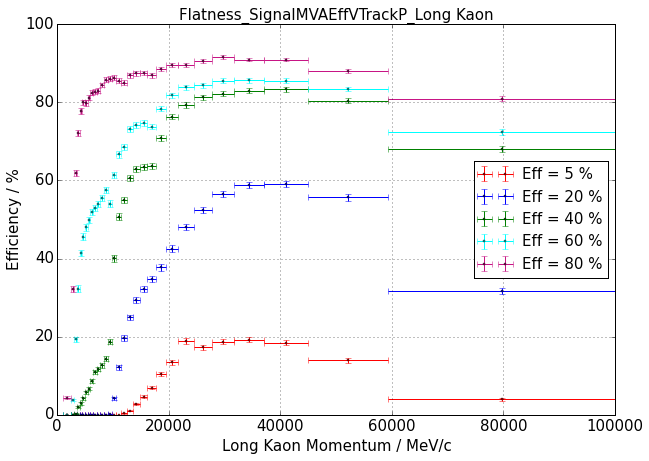

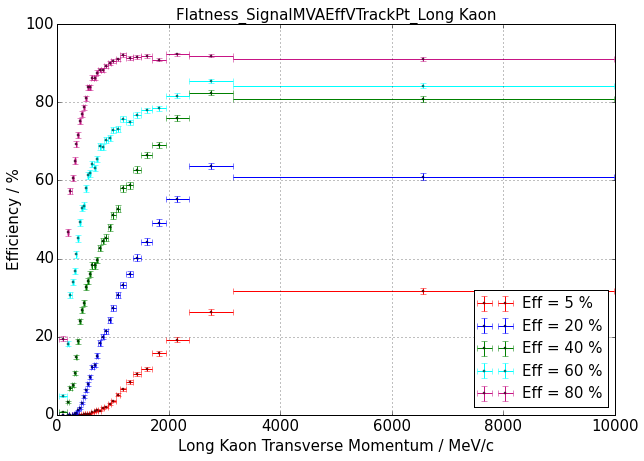

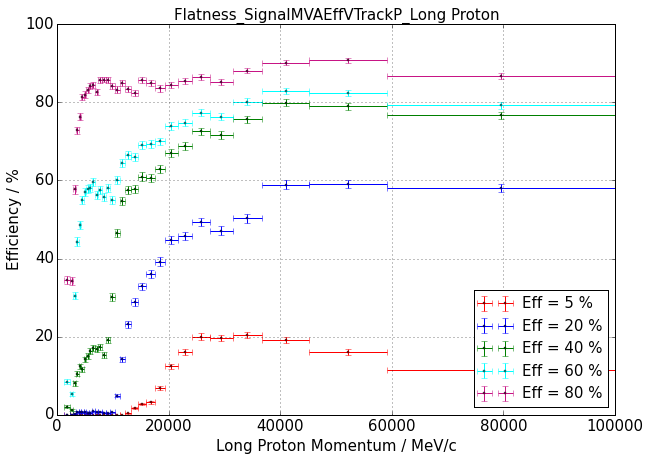

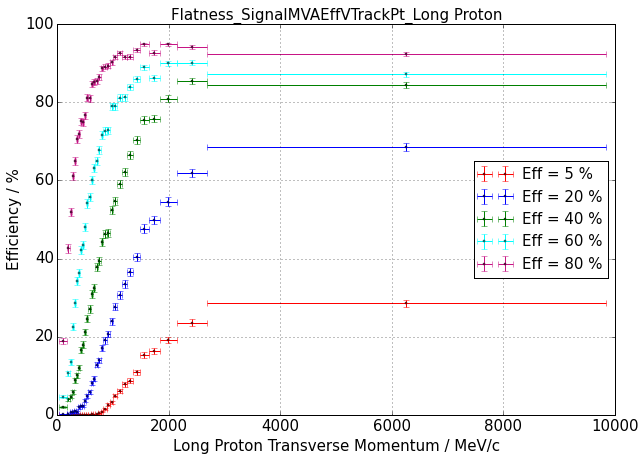

In [55]:
utils.get_all_flatness_figures(data_eval, proba_eval, labels_eval, 'Long', particles, save_path=new_work_path, show=True)